# Importing required packages and datasets from kaggle

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

In [2]:

import kagglehub
keras_pretrained_models_path =kagglehub.dataset_download("rakeshdasdata/keras-pretrained-models")
fer2013_path = kagglehub.dataset_download("rakeshdasdata/rakesh-fer-dataset")
emotion_detection_fer_path = kagglehub.dataset_download("rakeshdasdata/rakesh-emotion-detection-fer")


print('Data source import complete.')


100%|██████████| 943M/943M [00:12<00:00, 76.4MB/s]

Extracting files...


100%|██████████| 60.3M/60.3M [00:01<00:00, 39.1MB/s]

Extracting files...


100%|██████████| 65.2M/65.2M [00:00<00:00, 104MB/s] 

Extracting files...


Data source import complete.


Moving Datasets
Moves the downloaded datasets to the /content directory using shutil.move. This is done to ensure data persistence.

In [ ]:
import shutil
shutil.move(keras_pretrained_models_path, '/content/keras_pretrained_models_path') # Move to /content
shutil.move(fer2013_path, '/content/fer2013_path') # Move to /content
shutil.move(emotion_detection_fer_path, '/content/emotion_detection_fer_path') # Move to /content

# Inspired by the solution provided by chatGPT


'/content/emotion_detection_fer_path'

In [4]:
train_dir = "/content/fer2013_path/train" #passing the path with training images
test_dir = "/content/fer2013_path/test"   #passing the path with testing images

In [5]:
img_size = 48 #original size of the image

# Data Preprocessing and Augmentation

Defines the image size (img_size) and Creates ImageDataGenerator instances for data augmentation (train_datagen) and validation (validation_datagen).
Augmentation techniques include width/height shift, horizontal flip, and rescaling.
Creates data generators (train_generator, validation_generator) using flow_from_directory to load and preprocess images from the specified directories.

In [ ]:

train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)


train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

# Inspired by the work in the below source on Kaggle:
# "Face Emotion Detection" - https://www.kaggle.com/code/tejaswashrivastava/face-emotion

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


# Model Building and Compilation
Compiles the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric.

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001), # Change 'lr' to 'learning_rate'
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )


# Inspired by the work in the below source on Kaggle:
# "Face Emotion Detection" - https://www.kaggle.com/code/tejaswashrivastava/face-emotion


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
epochs = 60
batch_size = 64
history = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 51s 99ms/step - accuracy: 0.1820 - loss: 9.6156 - val_accuracy: 0.1872 - val_loss: 8.6692
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.2252 - loss: 8.5050 - val_accuracy: 0.2612 - val_loss: 7.5988
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.2406 - loss: 7.5485 - val_accuracy: 0.2856 - val_loss: 6.6726
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.2664 - loss: 6.5975 - val_accuracy: 0.3170 - val_loss: 5.7749
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.3048 - loss: 5.6728 - val_accuracy: 0.3736 - val_loss: 4.9333
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 62ms/step - accuracy: 0.3345 - loss: 4.8941 - val_accuracy: 0.3715 - val_loss: 4.2831
Epoch 7/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 23s 64ms/step - accuracy: 0.3662 - loss: 4.2196 - val_accuracy: 0.4120 - val_loss: 3.7116
Epoch 8/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - accuracy: 0.3871 - loss: 3.6836 - val_accurac

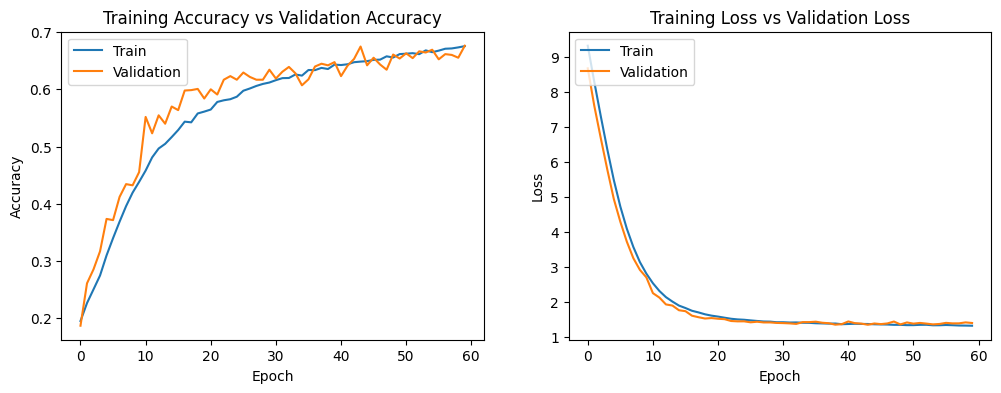

In [9]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
model.save('model_optimal.h5')

(48, 48)


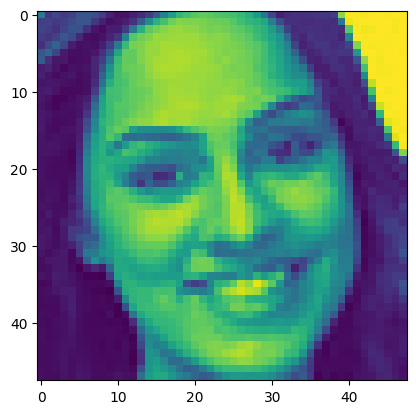

In [11]:
img = image.load_img("/content/fer2013_path/test/happy/PrivateTest_10613684.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape) #prints (48,48) that is the shape of our image

In [12]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [13]:
img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])
print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 999ms/step
[0.0, 0.0, 3.275112e-22, 1.0, 0.0, 0.0, 0.0]


In [14]:
img_index = result.index(max(result))
print(label_dict[img_index])
plt.show()

Happy


In [15]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.7181 - loss: 1.1940
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6842 - loss: 1.4147
final train accuracy = 71.88 , validation accuracy = 67.60


In [16]:
model.save_weights('model_weights.weights.h5')

In [17]:
!pip install gTTS
!pip install IPython
!pip install google

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00


In [18]:
!pip install SpeechRecognition

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 22.5 MB/s eta 0:00:00


In [19]:
from gtts import gTTS
from IPython.display import Audio
from google.colab import files
import speech_recognition as sr

# Text-to-Speech Function
def speak(text):
    """Converts text to speech and plays it in Google Colab."""
    try:
        tts = gTTS(text=text, lang='en')
        tts.save("temp.mp3")
        return Audio("temp.mp3", autoplay=True)
    except Exception as e:
        print(f"Error in text-to-speech: {e}")

# Speech-to-Text Function from Uploaded File
def listen_from_uploaded_file():
    """Uploads an audio file and performs speech recognition on it."""
    print("Please upload an audio file:")
    uploaded = files.upload()
    file_name = next(iter(uploaded))  # Get the uploaded file name

    r = sr.Recognizer()
    with sr.AudioFile(file_name) as source:
        audio = r.record(source)  # Read the entire audio file

    try:
        text = r.recognize_google(audio)
        print("You said:", text)
        return text
    except sr.UnknownValueError:
        print("Could not understand the audio.")
        return None
    except sr.RequestError as e:
        print(f"Could not request results from Google Speech Recognition service; {e}")
        return None

# Example Usage
# Mock emotion result
result = [0.1, 0.05, 0.2, 0.6, 0.03, 0.02, 0.0]  # Mock probabilities
label_dict = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Neutral', 5: 'Sad', 6: 'Surprise'}

# Detect emotion
img_index = result.index(max(result))  # Get index of highest probability
emotion = label_dict[img_index]  # Map to emotion label

# Speak the detected emotion
print("Playing the detected emotion response...")
Audio_response = speak(f"The detected emotion is {emotion}.")
Audio_response



Playing the detected emotion response...
